In [1]:
from lrfhss.run import *
import time
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pickle
import pandas as pd
import os
import scienceplots
from matplotlib.ticker import EngFormatter



# Sketch figures for the paper

## Equation

In [2]:
# Analytical Model from M. Asad Ullah, K. Mikhaylov and H. Alves,
# "Analysis and Simulation of LoRaWAN LR-FHSS for Direct-to-Satellite Scenario,"
# in IEEE Wireless Communications Letters, doi: 10.1109/LWC.2021.3135984.
# https://ieeexplore.ieee.org/document/9653679
def analytical_success(s: Settings):
    u_H = (s.number_nodes*s.headers)/s.average_interval
    u_F = (s.number_nodes*s.payloads)/s.average_interval
    A_H = u_H*2*s.header_duration + u_F*(s.header_duration+s.payload_duration)
    
    #P_H = 1 - (1- ((s.obw-1)/s.obw)**(A_H-1))**s.headers
    #These two are the same, just different shape!
    P_H = 1 - (1-(1-(1/s.obw))**(A_H-1))**s.headers

    A_F = u_F*2*s.payload_duration + u_H*(s.header_duration+s.payload_duration)
    p_F = (1-(1/s.obw))**(A_F-1)

    #threshold-> minimum payload packets to success
    k = range(0,s.threshold)
    P_F = 1- sum(sp.stats.binom.pmf(k,s.payloads, p_F))
    #These two also result in the same, the prior gives NaN for >1 values, and one below gives >1 results
    #for k in range(1,s.threshold):
    #    aux.append(sp.special.binom(s.payloads, k) * p_F**k * (1-p_F)**(s.payloads-k))
    #P_F = 1 - sum(aux)

    return P_H*P_F


## Figure 5: Success vs Window Size

In [ ]:
nNodes = 80000//8
loops = 2000

points = 21
windows = np.linspace(0.5, 2.5, points)
start = time.perf_counter()
steps = [0.1, 0.50, 1.00]
success_df = pd.DataFrame(index=windows)
cores = 60
for st in steps:
    print(f"---------------------------------------\nStarting step: {st}")
    success = np.array([])
    for w in windows:
        print(f"Starting window: {w}")
        s = Settings(number_nodes = nNodes, code='1/3', payload_size=10, base='acrda', transceiver_wait=0, window_size=w, window_step=st)
        results = Parallel(n_jobs=cores) (delayed(run_sim)(s, seed = seed) for seed in range(loops))
        success = np.append(success, np.mean(results))
    success_df[st] = success

s = Settings(number_nodes = nNodes, code='1/3', payload_size=10, base='acrda', transceiver_wait=0, window_size=2, window_step=0.1)
s.window_size= (s.simulation_time-1)/s.time_on_air
results = Parallel(n_jobs=cores) (delayed(run_sim)(s, seed = seed) for seed in range(loops))
inf_w = np.mean(results)


s = Settings(number_nodes = nNodes, code='1/3', payload_size=10, base='base', transceiver_wait=0)
results = Parallel(n_jobs=cores) (delayed(run_sim)(s, seed = seed) for seed in range(loops))
core_base = np.mean(results)

print(f"The simulation lasted {time.perf_counter()-start} seconds.")

if not os.path.exists('paper_sketches'):
    os.makedirs('paper_sketches')
file = open('paper_sketches/example3_2.data', 'wb')
pickle.dump([success_df, inf_w, core_base], file)
file.close()

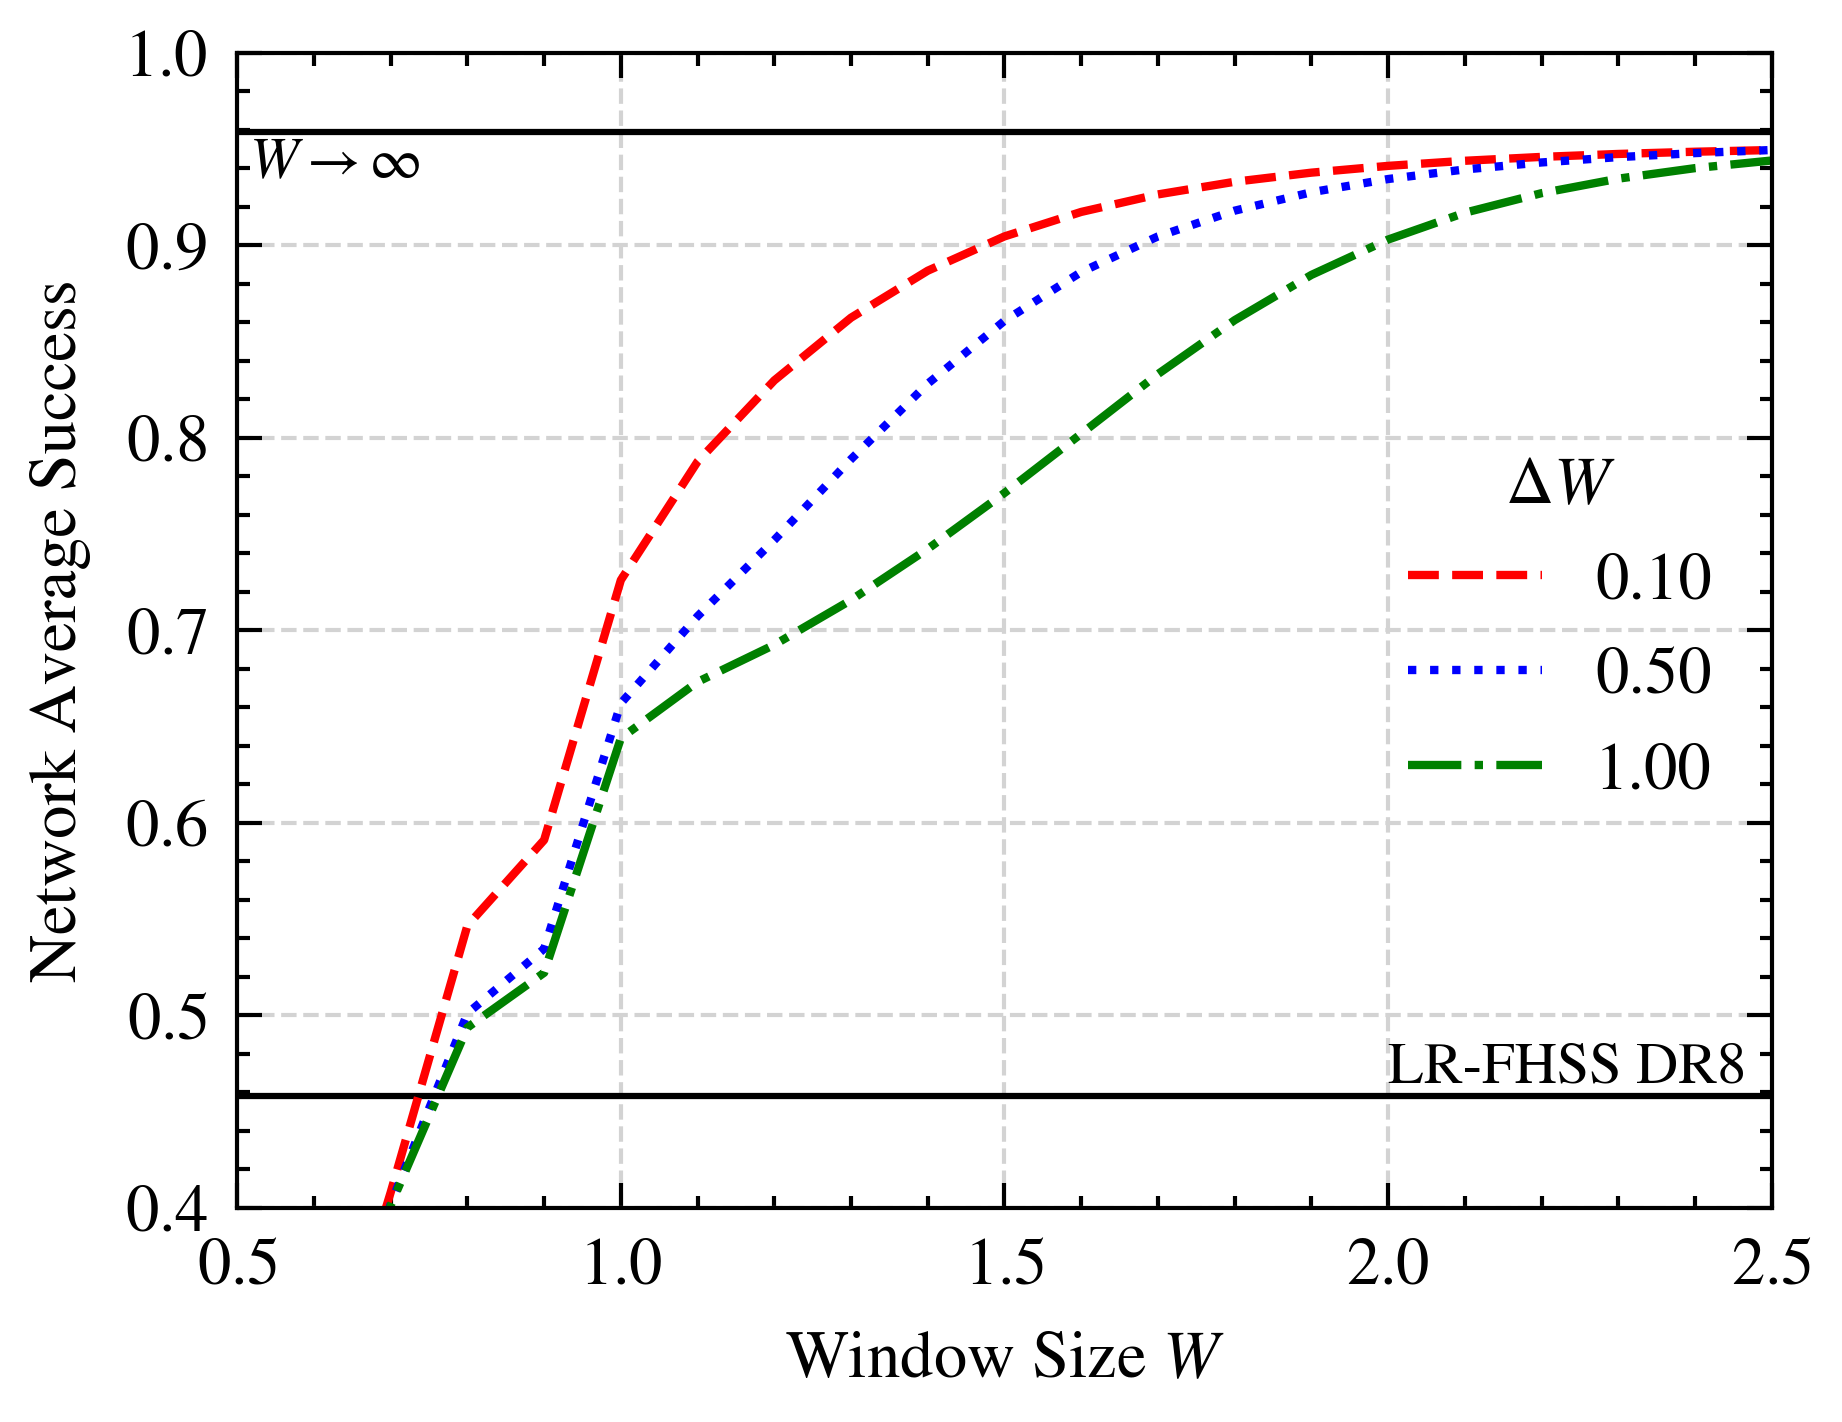

In [4]:
success_df = pd.read_pickle('paper_sketches/example3_2.data')[0]
success_inf = pd.read_pickle('paper_sketches/example3_2.data')[1]
success_base = pd.read_pickle('paper_sketches/example3_2.data')[2]

pparam = dict(xlabel='Window Size $W$', ylabel='Network Average Success')

with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    fig, ax = plt.subplots()
    ax.plot(success_df.index, np.full(len(success_df.index),success_base), linewidth=0.75)
    ax.text(2,0.465, 'LR-FHSS DR8', fontsize=7)
    ax.plot(success_df.index, success_df[0.10], label='0.10')
#    ax.plot(success_df.index, success_df[0.25])
    ax.plot(success_df.index, success_df[0.50], label='0.50')
    ax.plot(success_df.index, success_df[1.00], label='1.00')
    ax.plot(success_df.index, np.full(len(success_df.index),success_inf), linewidth=0.75)
    ax.text(0.515,0.935, r'$W \rightarrow \infty $', fontsize=7)
    ax.legend(title='$\Delta W$')
    ax.grid(ls='--', color='lightgray')
    ax.autoscale(tight=True)
    ax.set(**pparam)
    plt.ylim(0.4, 1)
    plt.xlim(0.5, 2.5)
    if not os.path.exists('figures'):
        os.makedirs('figures')
    fig.savefig('figures/example_3.eps', dpi=300)
    plt.show()
    plt.close()


## Figures 3, 4, 6, 7

In [ ]:
nNodes_points = 20
nNodes_min = 1000
nNodes_max = 200000
nNodes = np.linspace(nNodes_min, nNodes_max, nNodes_points, dtype=int)//8

loops = 1000

start = time.perf_counter()
codes = ['1/3', '2/3']
headers = [3, 2]
success_df = pd.DataFrame(index=nNodes)
throughput_df = pd.DataFrame(index=nNodes)
cores=60

for c,h in zip(codes, headers):
    success = np.array([[],[]])
    success_eqn = np.array([])
    success_30 = np.array([[],[]])
    success_30_eqn = np.array([])
    success_acrda = np.array([[],[]])
    success_30_acrda = np.array([[],[]])
    for n in nNodes:
        s = Settings(number_nodes = n, code=c, headers=h, payload_size=10, transceiver_wait=0)
        results = Parallel(n_jobs=cores) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))
        success_eqn = np.append(success_eqn, analytical_success(s))
        s = Settings(number_nodes = n//2, code=c, headers=h, payload_size=30, transceiver_wait=0)
        results_30 = Parallel(n_jobs=cores) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))
        success_30_eqn = np.append(success_30_eqn, analytical_success(s))
        s = Settings(number_nodes = n, code=c, headers=h, payload_size=10, transceiver_wait=0, base='acrda')
        results_acrda = Parallel(n_jobs=cores) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))
        s = Settings(number_nodes = n//2, code=c, headers=h, payload_size=30, transceiver_wait=0, base='acrda')
        results_30_acrda = Parallel(n_jobs=cores) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))
        success = np.append(success, np.mean(results,0), axis=1)
        success_30 = np.append(success_30, np.mean(results_30,0), axis=1)
        success_acrda = np.append(success_acrda, np.mean(results_acrda,0), axis=1)
        success_30_acrda = np.append(success_30_acrda, np.mean(results_30_acrda,0), axis=1)
        print(f"Finished code {c} Nodes: {n*8}")
    success_df[c+'_10'] = success[0]
    success_df[c+'_30'] = success_30[0]
    success_df[c+'_10_eqn'] = success_eqn
    success_df[c+'_30_eqn'] = success_30_eqn
    success_df[c+'_10_acrda'] = success_acrda[0]
    success_df[c+'_30_acrda'] = success_30_acrda[0]
    throughput_df[c+'_10'] = success[1]
    throughput_df[c+'_30'] = success_30[1]
    throughput_df[c+'_10_acrda'] = success_acrda[1]
    throughput_df[c+'_30_acrda'] = success_30_acrda[1]
print(f"The simulation lasted {time.perf_counter()-start} seconds.")

if not os.path.exists('paper_sketches'):
    os.makedirs('paper_sketches')
file = open('paper_sketches/example4_throughput.data', 'wb')
pickle.dump([success_df, throughput_df], file)
file.close()

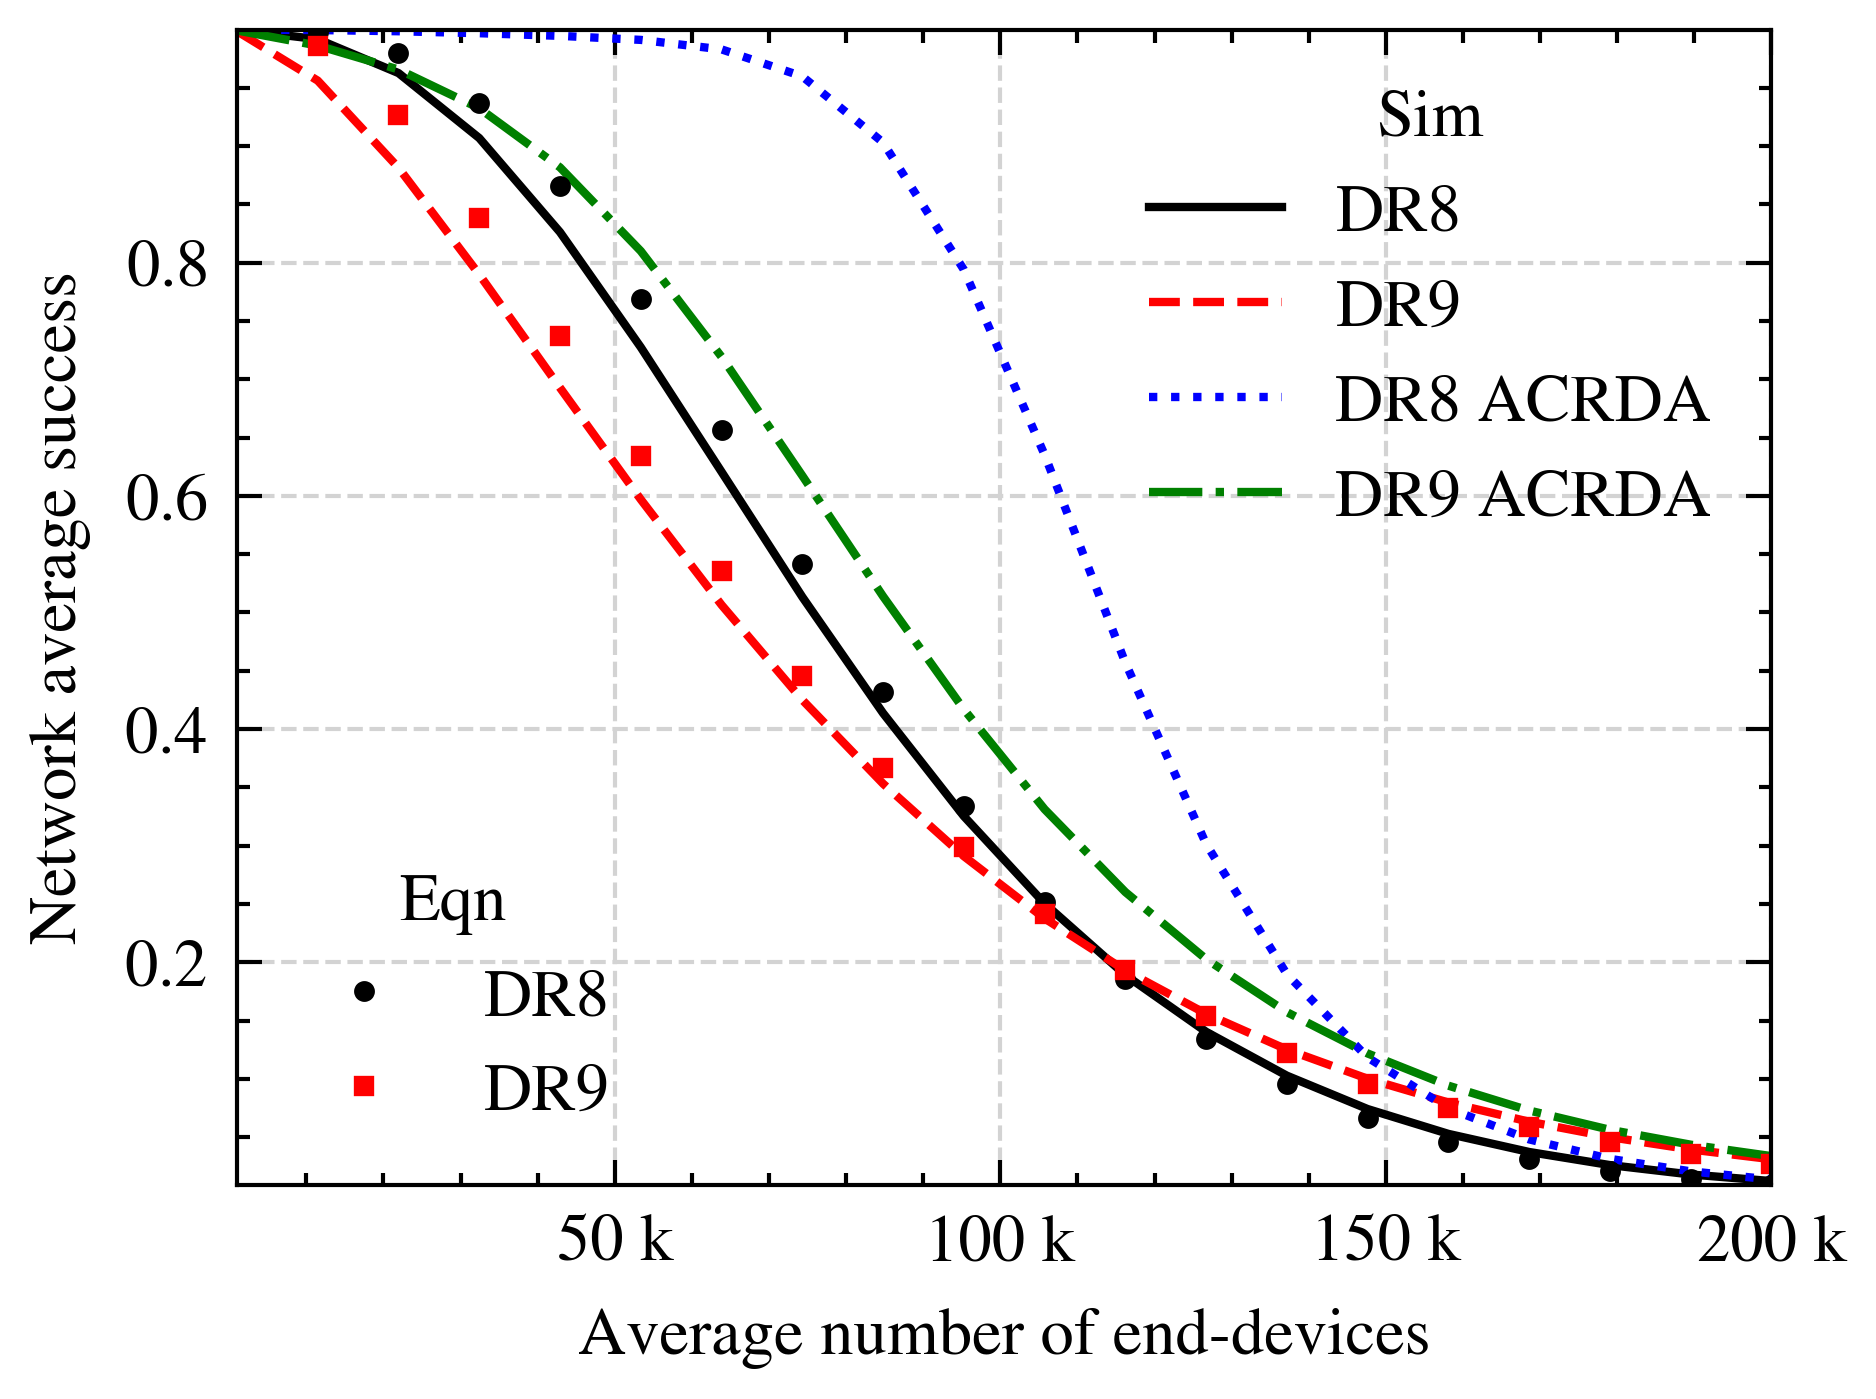

In [5]:
success_df = pd.read_pickle('paper_sketches/example4_throughput.data')[0]

pparam = dict(xlabel='Average number of end-devices', ylabel='Network average success')
f_x = EngFormatter()


with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(f_x)
    ax.plot(success_df.index*8, success_df['1/3_10'], label='DR8')
    ax.plot(success_df.index*8, success_df['2/3_10'], label='DR9')
    ax.plot(success_df.index*8, success_df['1/3_10_acrda'], label='DR8 ACRDA')
    ax.plot(success_df.index*8, success_df['2/3_10_acrda'], label='DR9 ACRDA')
    ax.plot(success_df.index*8, success_df['1/3_10_eqn'], 'k.', markersize=3, label='DR8')
    ax.plot(success_df.index*8, success_df['2/3_10_eqn'], 'rs', markersize=1.5, label='DR9')

    lines = plt.gca().get_lines()
    legend1 = ax.legend([lines[i] for i in [0,1,2,3]],[lines[i].get_label() for i in [0,1,2,3]], loc=1,title='Sim')
    legend2 = ax.legend([lines[i] for i in [4,5]],[lines[i].get_label() for i in [4,5]],  loc='lower left',title='Eqn')
    plt.gca().add_artist(legend1)

    #ax.legend(loc='lower left')
    ax.grid(ls='--', color='lightgray')
    ax.autoscale(tight=True)
    ax.set(**pparam)
    fig.savefig('figures/example_4_1.eps', dpi=300)
    plt.show()
    plt.close()


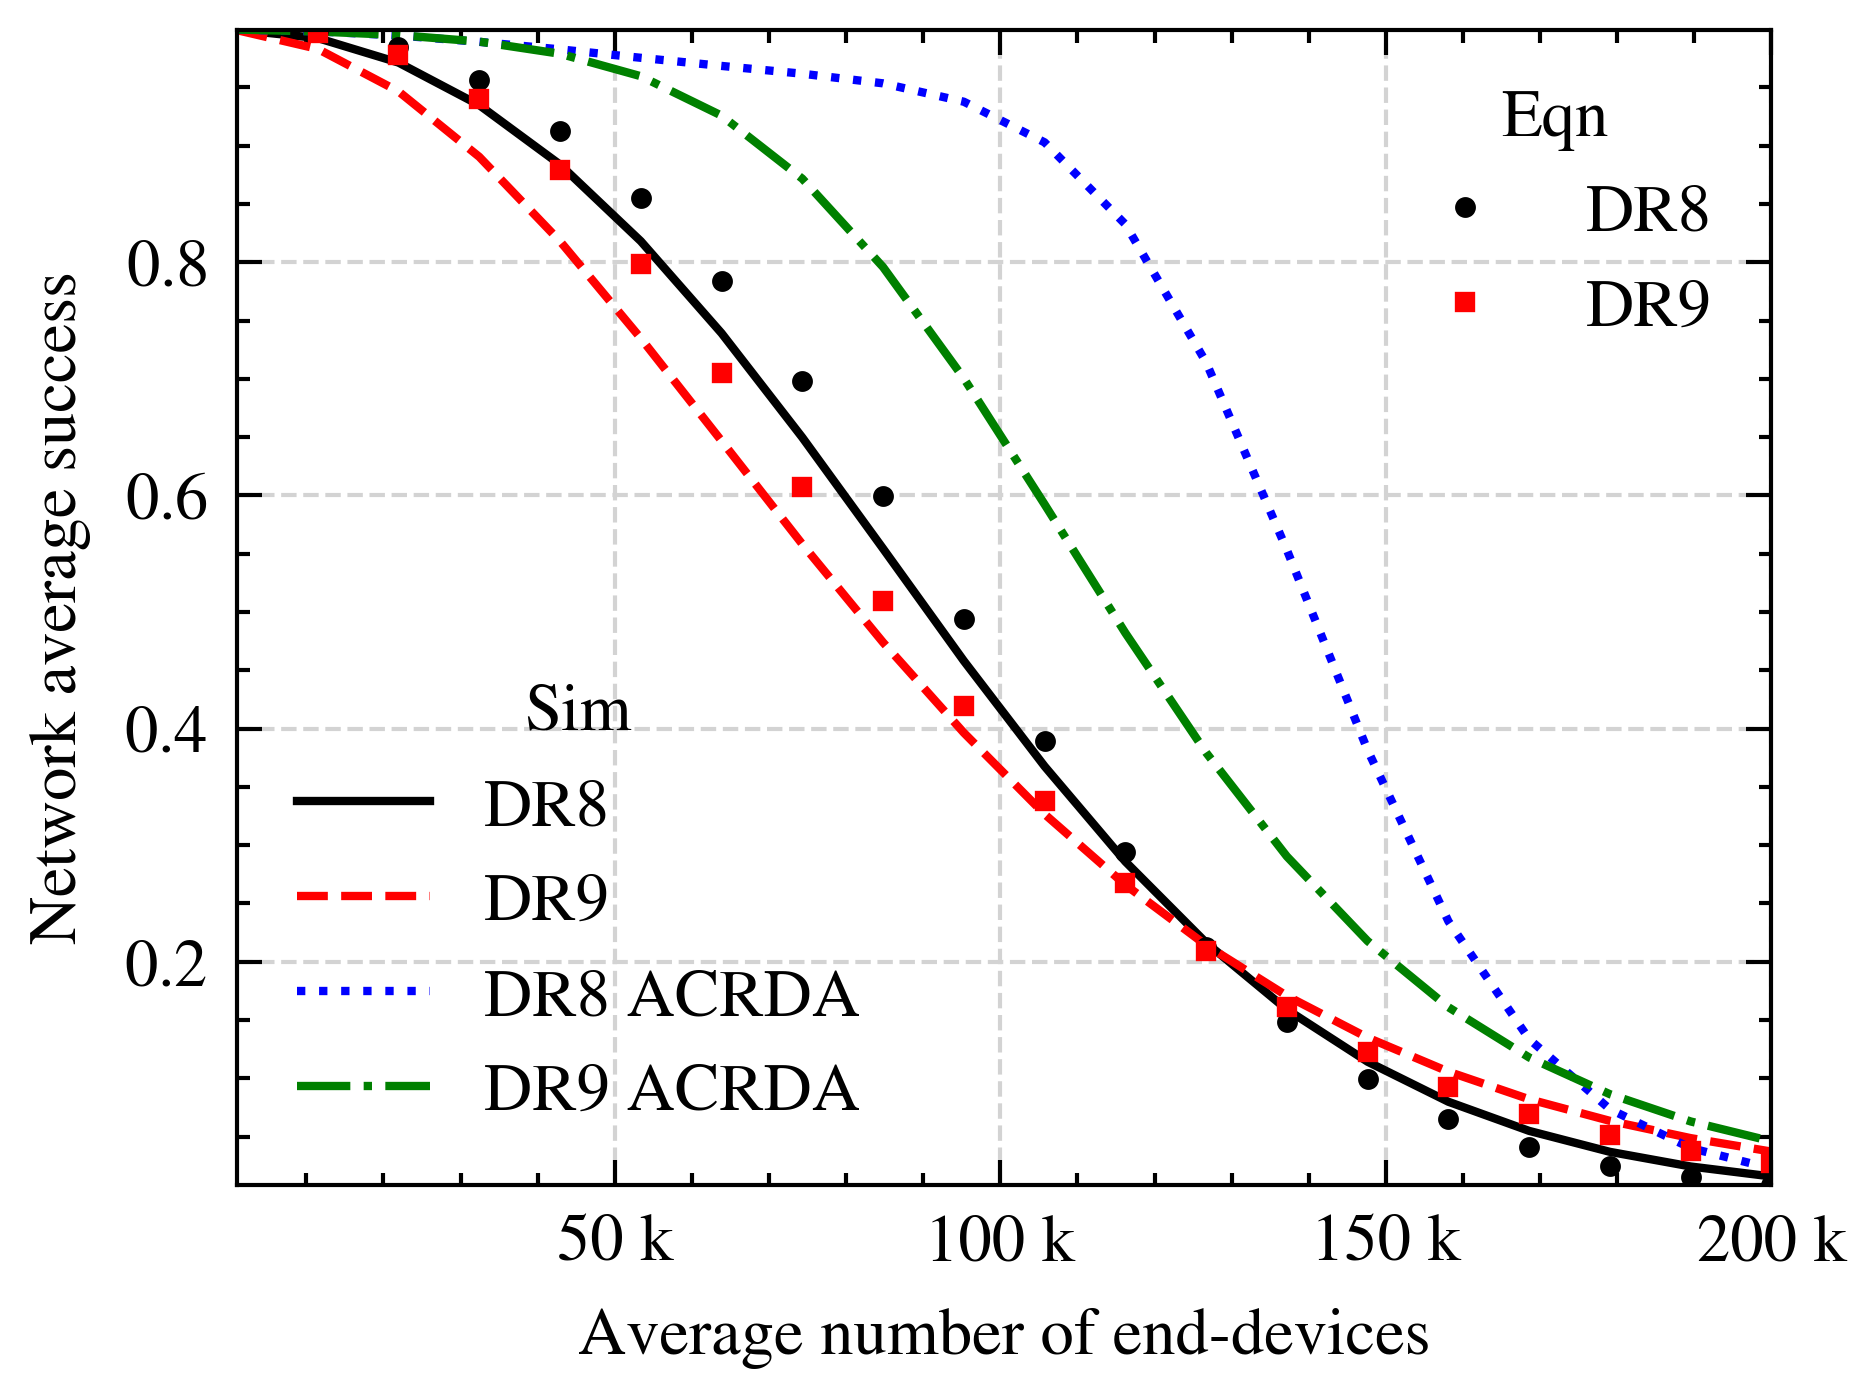

In [6]:
success_df = pd.read_pickle('paper_sketches/example4_throughput.data')[0]

pparam = dict(xlabel='Average number of end-devices', ylabel='Network average success')
f_x = EngFormatter()

with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(f_x)
    ax.plot(success_df.index*8, success_df['1/3_30'], label='DR8')
    ax.plot(success_df.index*8, success_df['2/3_30'], label='DR9')
    ax.plot(success_df.index*8, success_df['1/3_30_acrda'], label='DR8 ACRDA')
    ax.plot(success_df.index*8, success_df['2/3_30_acrda'], label='DR9 ACRDA')
    ax.plot(success_df.index*8, success_df['1/3_30_eqn'], 'k.', markersize=3, label='DR8')
    ax.plot(success_df.index*8, success_df['2/3_30_eqn'], 'rs', markersize=1.5, label='DR9')

    lines = plt.gca().get_lines()
    legend1 = ax.legend([lines[i] for i in [0,1,2,3]],[lines[i].get_label() for i in [0,1,2,3]], loc='lower left',title='Sim')
    legend2 = ax.legend([lines[i] for i in [4,5]],[lines[i].get_label() for i in [4,5]],  loc=1,title='Eqn')
    plt.gca().add_artist(legend1)

    ax.grid(ls='--', color='lightgray')
    ax.autoscale(tight=True)
    ax.set(**pparam)
    fig.savefig('figures/example_4_2.eps', dpi=300)
    plt.show()
    plt.close()


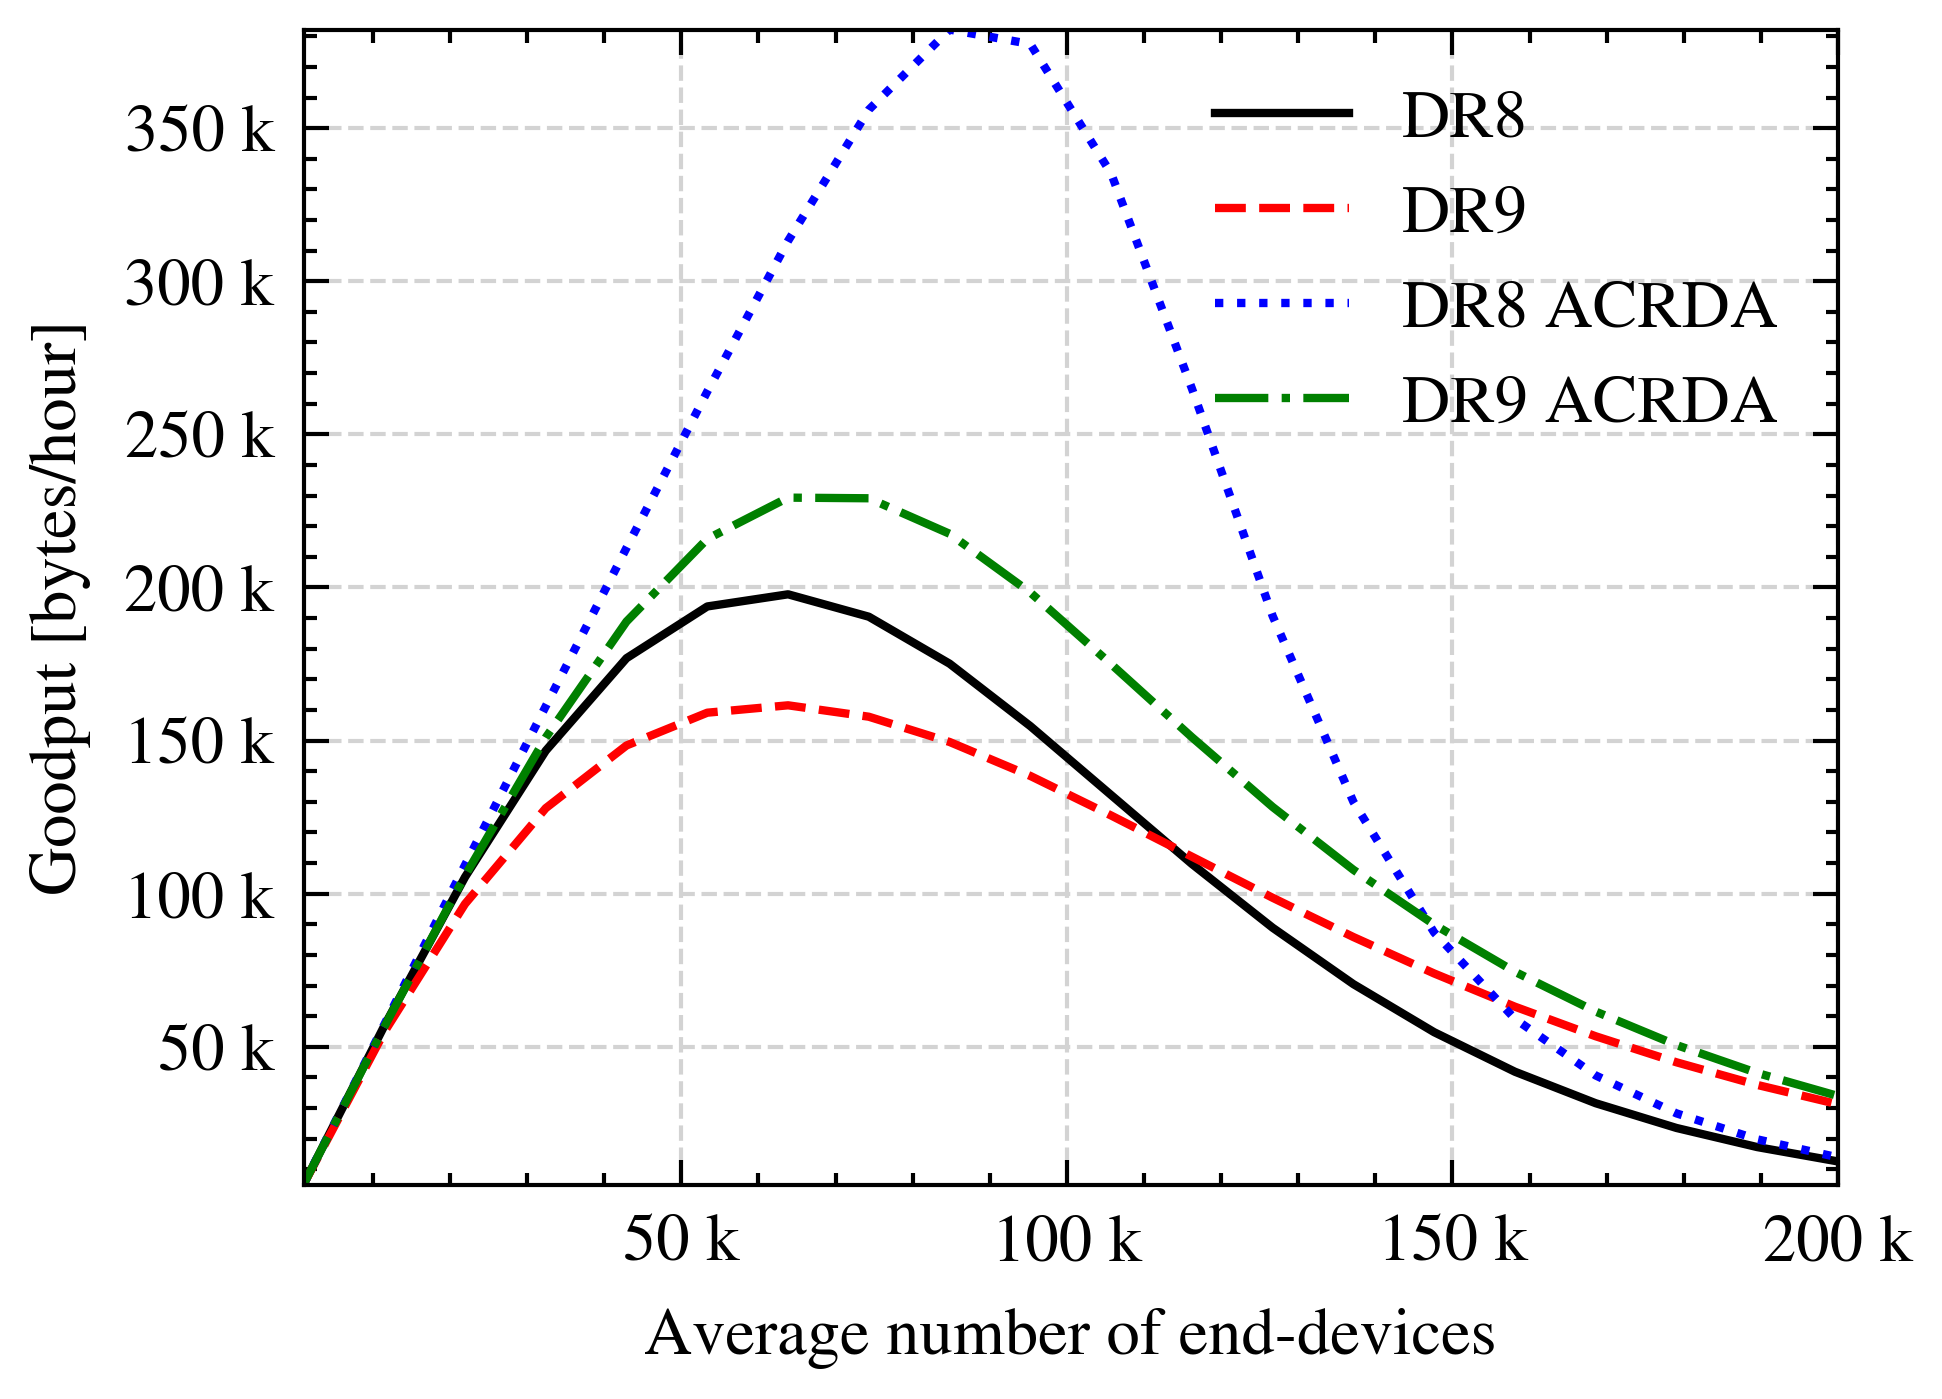

In [7]:
throughput_df = pd.read_pickle('paper_sketches/example4_throughput.data')[1]

pparam = dict(xlabel='Average number of end-devices', ylabel='Goodput [bytes/hour]')
f_x = EngFormatter()
f_y = EngFormatter()

with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(f_x)
    ax.yaxis.set_major_formatter(f_y)
    ax.plot(throughput_df.index*8, throughput_df['1/3_10'])
    ax.plot(throughput_df.index*8, throughput_df['2/3_10'])
    ax.plot(throughput_df.index*8, throughput_df['1/3_10_acrda'])
    ax.plot(throughput_df.index*8, throughput_df['2/3_10_acrda'])
    ax.legend(['DR8', 'DR9', 'DR8 ACRDA', 'DR9 ACRDA'])
    ax.grid(ls='--', color='lightgray')
    ax.autoscale(tight=True)
    ax.set(**pparam)
    fig.savefig('figures/example_4_3.eps', dpi=300)
    plt.show()
    plt.close()


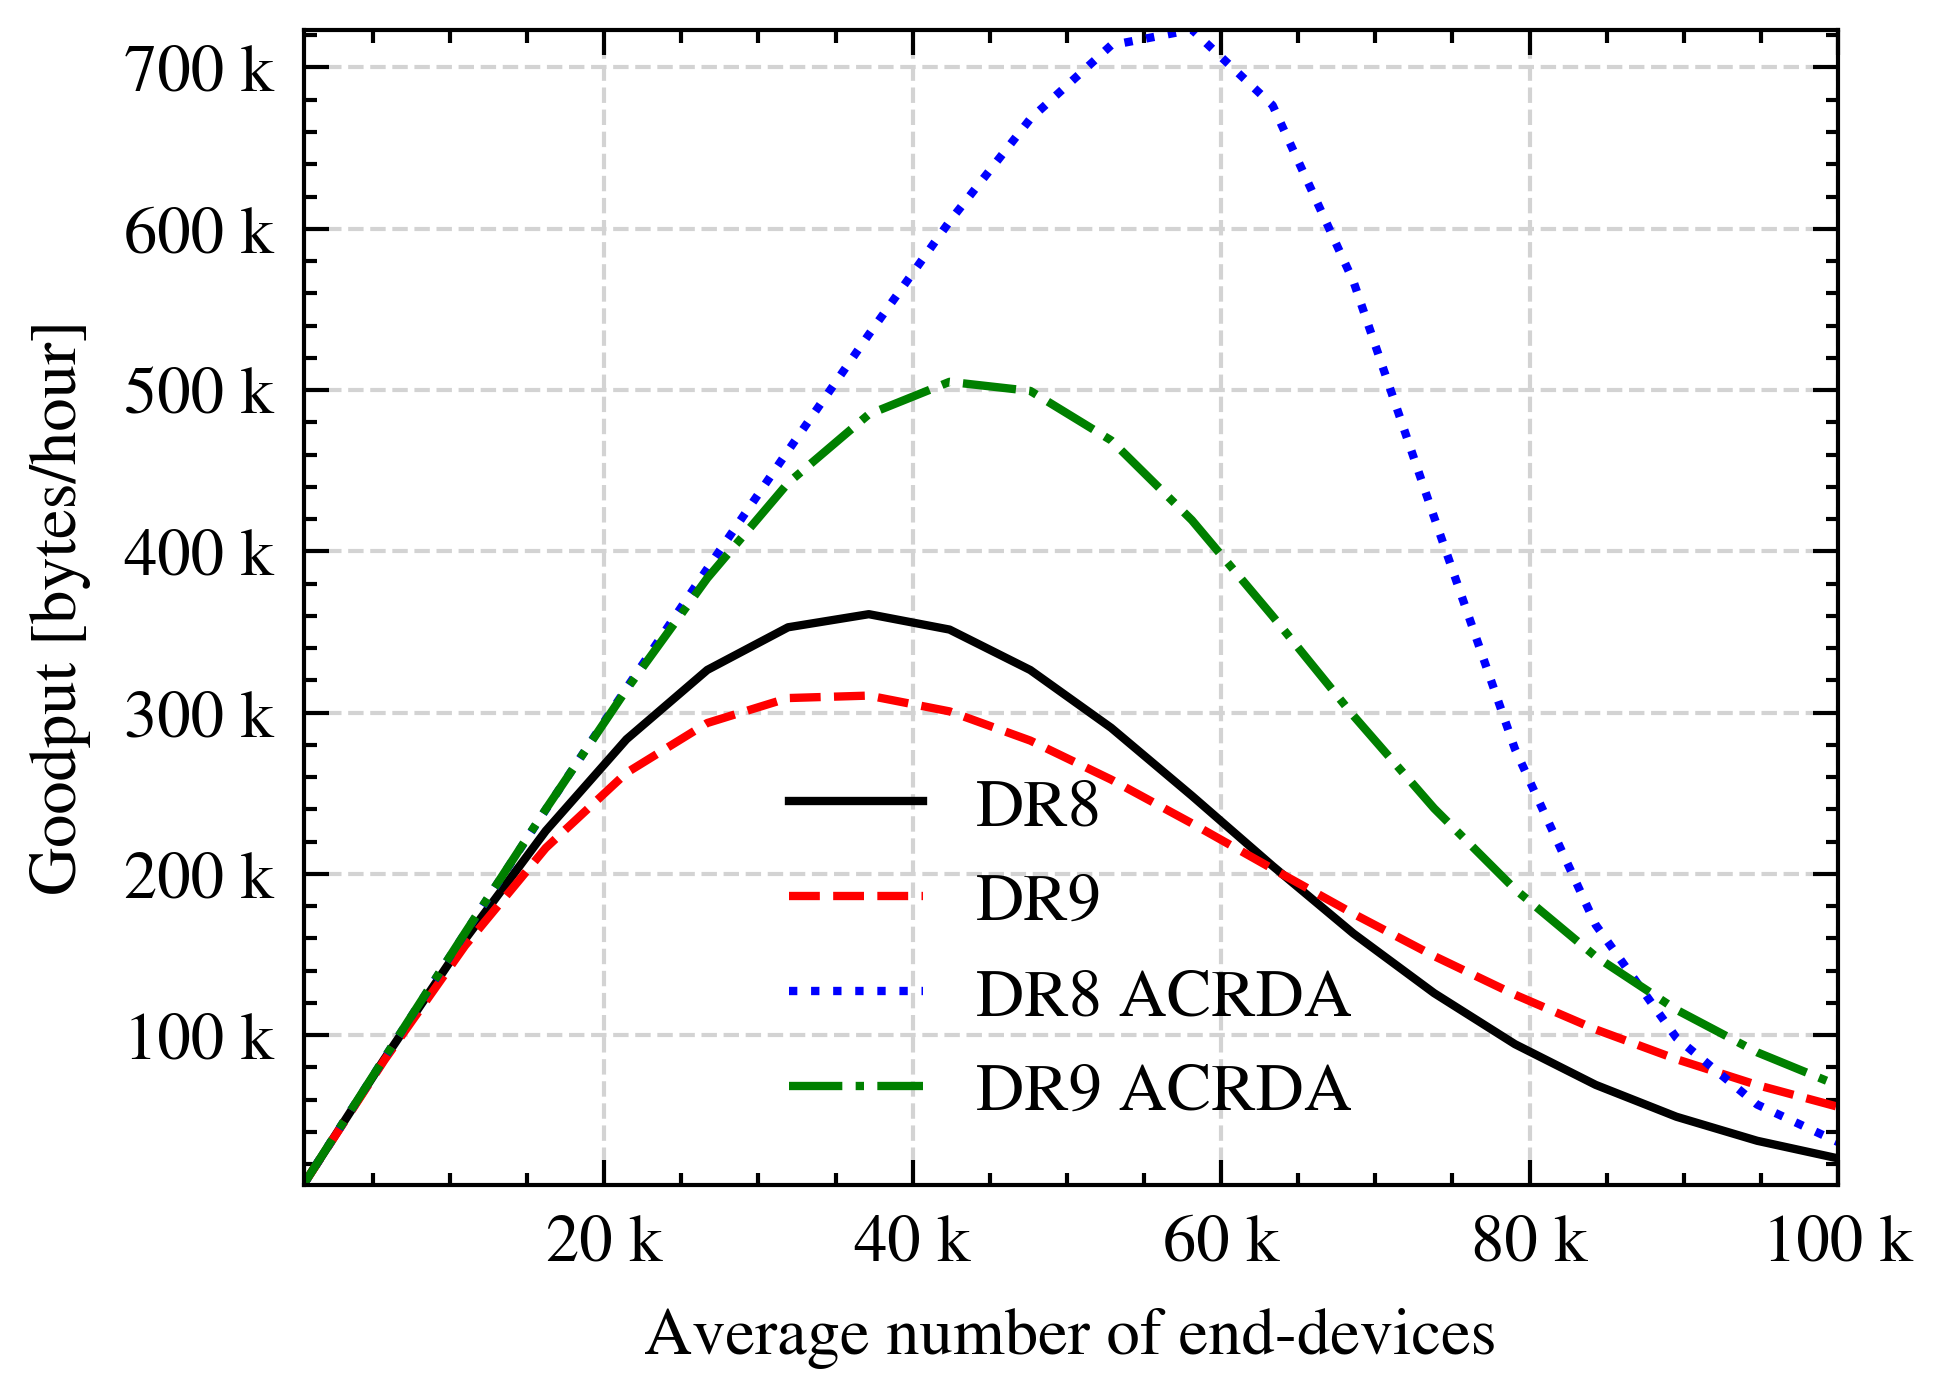

In [8]:
throughput_df = pd.read_pickle('paper_sketches/example4_throughput.data')[1]

pparam = dict(xlabel='Average number of end-devices', ylabel='Goodput [bytes/hour]')
f_x = EngFormatter()
f_y = EngFormatter()

with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(f_x)
    ax.yaxis.set_major_formatter(f_y)
    ax.plot(throughput_df.index*8//2, throughput_df['1/3_30'])
    ax.plot(throughput_df.index*8//2, throughput_df['2/3_30'])
    ax.plot(throughput_df.index*8//2, throughput_df['1/3_30_acrda'])
    ax.plot(throughput_df.index*8//2, throughput_df['2/3_30_acrda'])
    ax.legend(['DR8', 'DR9', 'DR8 ACRDA', 'DR9 ACRDA'],loc=8)
    ax.grid(ls='--', color='lightgray')
    ax.autoscale(tight=True)
    ax.set(**pparam)
    fig.savefig('figures/example_4_4.eps', dpi=300)
    plt.show()
    plt.close()


## Figure 8, 9

In [ ]:
payloads = [10,30,50]
target_success = 0.90
error = 0.001
loops = 1000
codes = ['1/3', '2/3']
base = ['core','acrda']
headers = [3, 2]
df = pd.DataFrame(index=payloads)

for bs in base:
    for c,h in zip(codes, headers):
        users = []
        guess = 30_000//8
        minimum = 10_000//8
        maximum = 100_000//8
        for p in payloads:
            success = 0
            print(f'Starting payload {p} with code {c}')
            while True:
                print(f'Starting with guess: {guess*8}, maximum: {maximum*8} and minimum: {minimum*8}')
                s = Settings(number_nodes = guess, code=c, headers=h, payload_size=p, transceiver_wait=0, base = bs)
                results = Parallel(n_jobs=12) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))
                success = np.mean(results)
                print(f'Guess {guess*8} resulted in {success}')
                if abs(success-target_success)<error:
                    break
                if success < target_success:
                    maximum = guess
                    guess = (guess+minimum)//2
                else:
                    minimum = guess
                    guess = (guess+maximum)//2
            users.append(guess)
            print(f'\n\n---------------------------------\n\n')
            maximum = int(guess*1.2)
            guess = int(guess*0.8)
            minimum = int(guess*0.5)
        df[c+'_'+bs] = users
        

if not os.path.exists('paper_sketches'):
    os.makedirs('paper_sketches')
file = open('paper_sketches/example5.data', 'wb')
pickle.dump(df, file)
file.close()

In [ ]:
payloads = [10,30,50]
target_success = 0.80
error = 0.001
loops = 1000
codes = ['1/3', '2/3']
base = ['acrda','core']
headers = [3, 2]
df = pd.DataFrame(index=payloads)

for bs in base:
    for c,h in zip(codes, headers):
        users = []
        guess = 60_000//8
        minimum = 20_000//8
        maximum = 100_000//8
        for p in payloads:
            success = 0
            print(f'Starting payload {p} with code {c}')
            while True:
                print(f'Starting with guess: {guess*8}, maximum: {maximum*8} and minimum: {minimum*8}')
                s = Settings(number_nodes = guess, code=c, headers=h, payload_size=p, transceiver_wait=0, base = bs)
                results = Parallel(n_jobs=12) (delayed(run_sim)(s, seed = seed) for seed in range(0,loops))
                success = np.mean(results)
                print(f'Guess {guess*8} resulted in {success}')
                if abs(success-target_success)<error:
                    break
                if success < target_success:
                    maximum = guess
                    guess = (guess+minimum)//2
                else:
                    minimum = guess
                    guess = (guess+maximum)//2
            users.append(guess)
            print(f'\n\n---------------------------------\n\n')
            maximum = int(guess)
            guess = int(guess*0.8)
            minimum = int(guess*0.4)
        df[c+'_'+bs] = users
        

if not os.path.exists('paper_sketches'):
    os.makedirs('paper_sketches')
file = open('paper_sketches/example5_2.data', 'wb')
pickle.dump(df, file)
file.close()

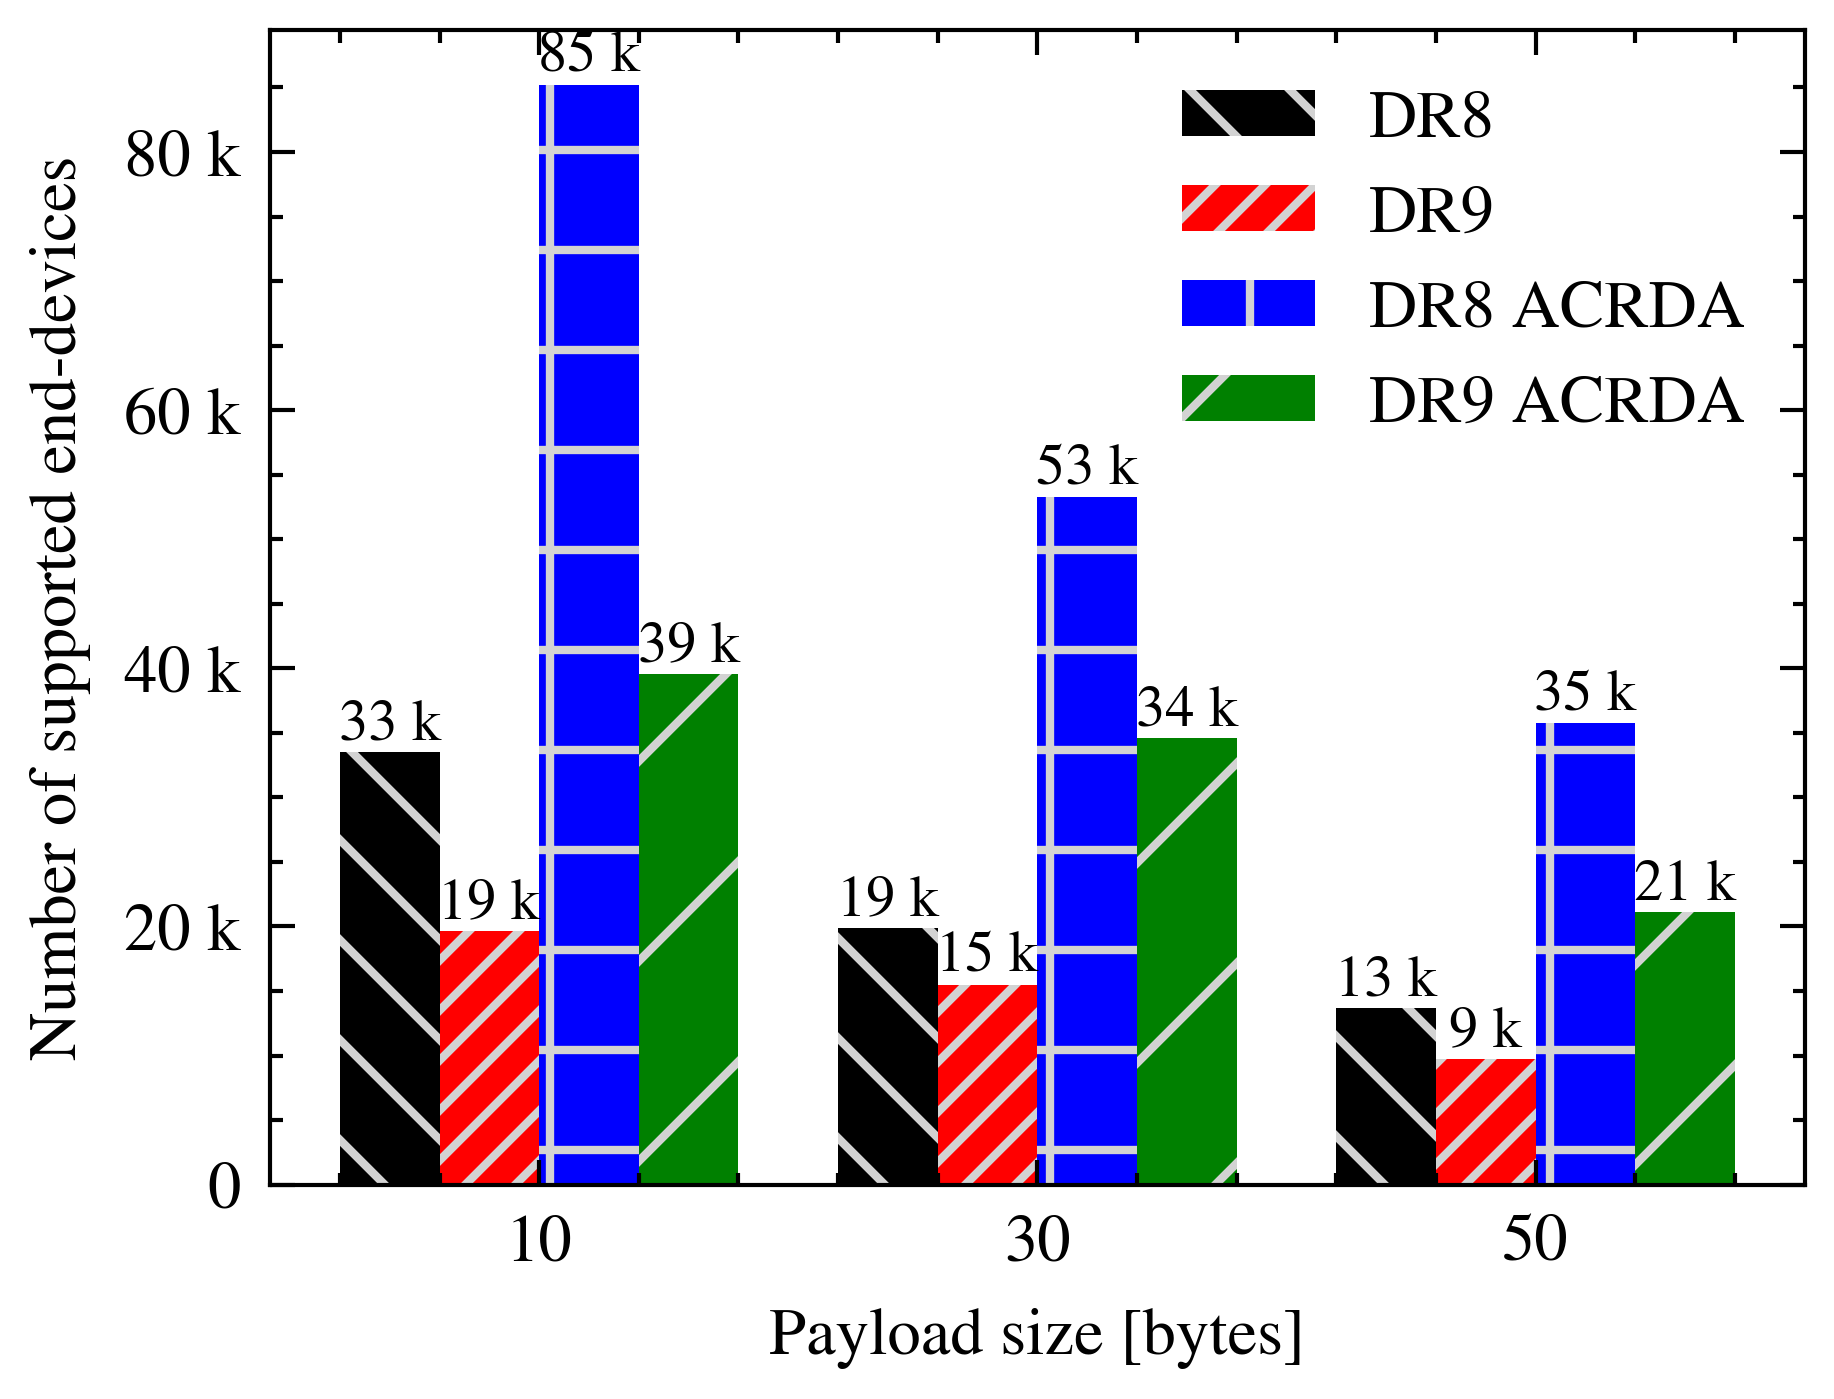

In [9]:
df = pd.read_pickle('paper_sketches/example5.data')
index = df.index.values
x = np.arange(len(index))
width = 0.2
pparam = dict(xlabel='Payload size [bytes]', ylabel='Number of supported end-devices')
f_y = EngFormatter()

with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    plt.rcParams['hatch.color'] = 'lightgray'
    colors = prop_cycle.by_key()['color']
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(f_y)
    bar1 = ax.bar(x - 3*width/2, df['1/3_core']*8, width, label='DR8', hatch='\\\\')
    bar2 = ax.bar(x - width/2, df['2/3_core']*8, width, label='DR9', hatch='////')
    bar3 = ax.bar(x + width/2, df['1/3_acrda']*8, width, label='DR8 ACRDA', hatch='+')
    bar4 = ax.bar(x + 3*width/2, df['2/3_acrda']*8, width, label='DR9 ACRDA', hatch='/')
    ax.set_xticks(x, index)
    l = ax.legend(loc = 'best', ncol=1)
    ax.set(**pparam)

    ax.bar_label(bar1,labels=list(map((lambda x: x+ ' k'), list(map(str, (df['1/3_core']*8).values//1000)))), fontsize=7)
    ax.bar_label(bar2,labels=list(map((lambda x: x+ ' k'), list(map(str, (df['2/3_core']*8).values//1000)))), fontsize=7)
    ax.bar_label(bar3,labels=list(map((lambda x: x+ ' k'), list(map(str, (df['1/3_acrda']*8).values//1000)))), fontsize=7)
    ax.bar_label(bar4,labels=list(map((lambda x: x+ ' k'), list(map(str, (df['2/3_acrda']*8).values//1000)))), fontsize=7)
    plt.show()
    fig.savefig('figures/example_5_2.eps', dpi=300)
    plt.close()

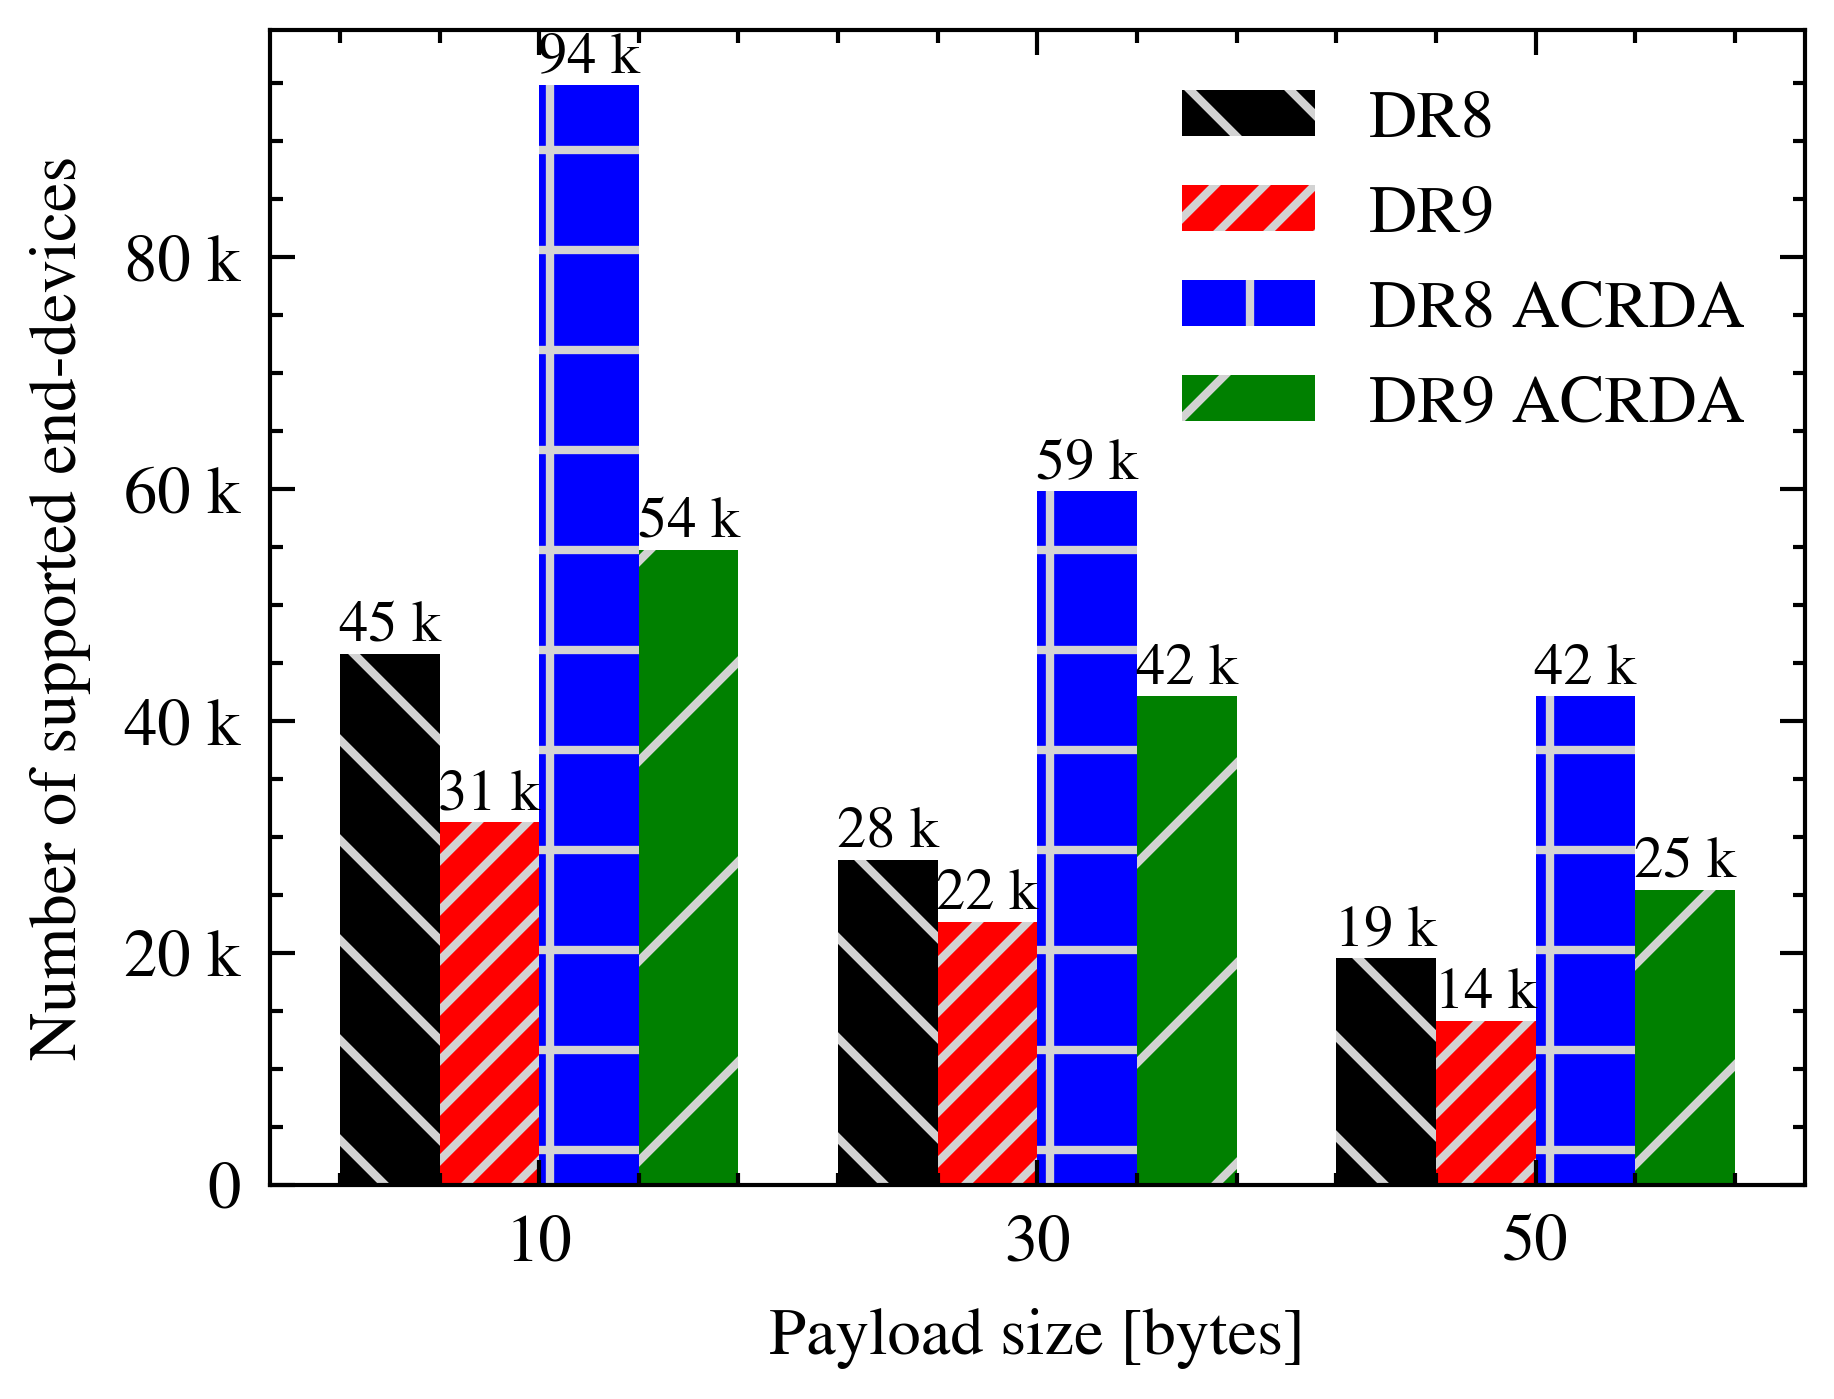

In [10]:
df = pd.read_pickle('paper_sketches/example5_2.data')
index = df.index.values
x = np.arange(len(index))
width = 0.2
pparam = dict(xlabel='Payload size [bytes]', ylabel='Number of supported end-devices')
f_y = EngFormatter()

with plt.style.context(['science', 'ieee', 'no-latex']):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    plt.rcParams['hatch.color'] = 'lightgray'
    colors = prop_cycle.by_key()['color']
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(f_y)
    bar1 = ax.bar(x - 3*width/2, df['1/3_core']*8, width, label='DR8', hatch='\\\\')
    bar2 = ax.bar(x - width/2, df['2/3_core']*8, width, label='DR9', hatch='////')
    bar3 = ax.bar(x + width/2, df['1/3_acrda']*8, width, label='DR8 ACRDA', hatch='+')
    bar4 = ax.bar(x + 3*width/2, df['2/3_acrda']*8, width, label='DR9 ACRDA', hatch='/')
    ax.set_xticks(x, index)
    l = ax.legend(loc = 'best', ncol=1)
    ax.set(**pparam)

    #setting bar labels
    ax.bar_label(bar1,labels=list(map((lambda x: x+ ' k'), list(map(str, (df['1/3_core']*8).values//1000)))), fontsize=7)
    ax.bar_label(bar2,labels=list(map((lambda x: x+ ' k'), list(map(str, (df['2/3_core']*8).values//1000)))), fontsize=7)
    ax.bar_label(bar3,labels=list(map((lambda x: x+ ' k'), list(map(str, (df['1/3_acrda']*8).values//1000)))), fontsize=7)
    ax.bar_label(bar4,labels=list(map((lambda x: x+ ' k'), list(map(str, (df['2/3_acrda']*8).values//1000)))), fontsize=7)
    plt.show()
    fig.savefig('figures/example_5_2.eps', dpi=300)
    plt.close()